# Max-P Regionalization for Multiple Components

Authors: [Sergio Rey](https://github.com/sjsrey), [James Gaboardi](https://github.com/jGaboardi)


The `max-p` problem involves the clustering of a set of geographic areas into the maximum number of homogeneous regions such that the value of a spatially extensive regional attribute is above a predefined threshold value. The spatially extensive attribute can be specified to ensure that each region contains sufficient population size, or a minimum number of enumeration units. The number of regions $p$ is endogenous to the problem and is useful for regionalization problems where the analyst does not require a fixed number of regions a-priori.

Originally formulated as a mixed-integer problem in [Duque, Anselin, Rey (2012)](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1467-9787.2011.00743.x), `max-p` is an [NP-hard problem](https://en.wikipedia.org/wiki/NP-hardness) and exact solutions are only feasible for small problem sizes. As such, a number of heuristic solution approaches have been suggested. PySAL implements the heuristic approach described in
[Wei, Rey, and Knaap (2020)](https://www.tandfonline.com/doi/full/10.1080/13658816.2020.1759806).

One issue with the current version of maxp is when it is applied to a collection of areas that have multiple connected components *and* some of the components do not allow for feasible region building.

In this notebook we outline a number of alternatives to use when encountering infeasible components.

In [1]:
%config InlineBackend.figure_format = "retina"
%load_ext watermark
%watermark

Last updated: 2022-10-23T00:36:02.617287-04:00

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

Compiler    : Clang 13.0.1 
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [2]:
import geopandas
import libpysal
import matplotlib.pyplot as plt
import numpy
import scipy
from scipy.spatial import KDTree
import shapely
from shapely.geometry import Polygon, box
import spopt
from spopt.region import MaxPHeuristic as MaxP
import warnings

plt.rcParams["figure.figsize"] = [12, 8]
warnings.filterwarnings("ignore")

RANDOM_SEED = 123456

%watermark -w
%watermark -iv

Watermark: 2.3.1

shapely   : 1.8.5
json      : 2.0.9
matplotlib: 3.6.1
libpysal  : 4.6.2
scipy     : 1.9.1
spopt     : 0.4.1+200.g336f235.dirty
numpy     : 1.23.3
geopandas : 0.11.1



In [3]:
n_cols = 5
n_rows = 10
b = 0
h = w = 10
component_0 = [box(l * w, b, l * w + w, b + h) for l in range(n_cols)]
b = b + h * 2
component_1 = [
    box(l * w, b + h * r, l * w + w, b + h + h * r)
    for r in range(n_rows)
    for l in range(n_cols)
]
geometries = component_0 + component_1

In [4]:
len(geometries)

55

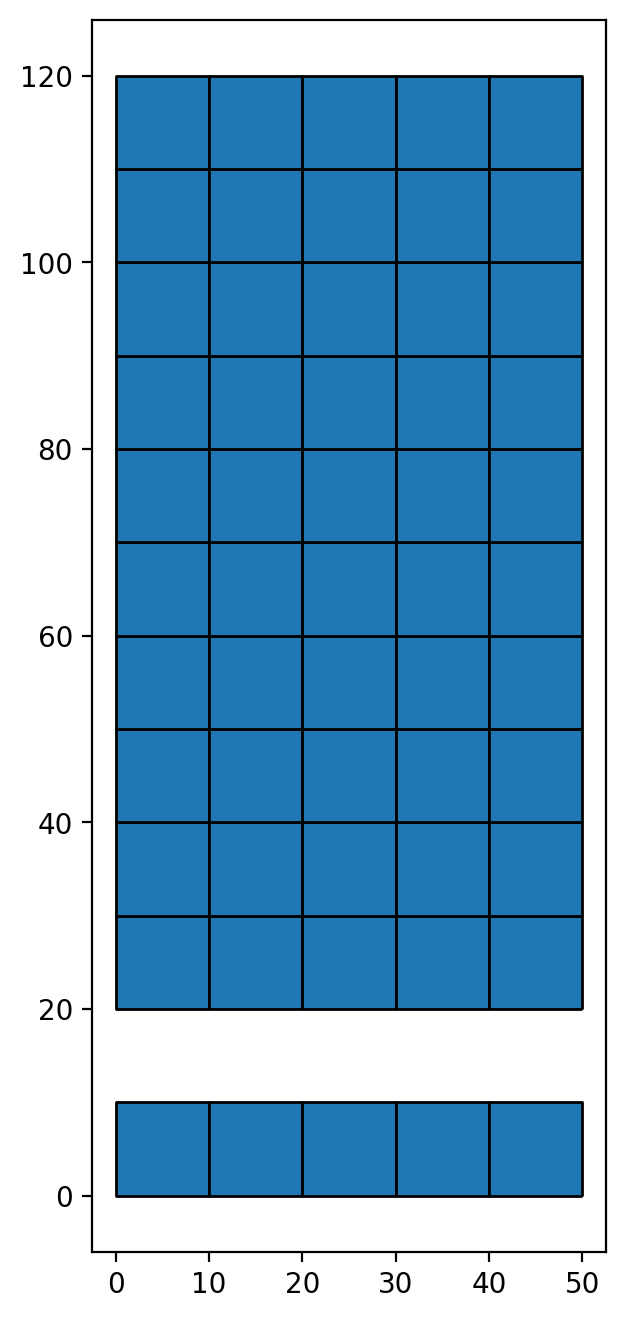

In [5]:
gdf = geopandas.GeoDataFrame(
    geometry=geometries,
    data=numpy.ones((n_cols * n_rows + n_cols, 1), int),
    columns=["var"],
)
gdf.plot(edgecolor="black");

In [6]:
gdf.head()

,var,geometry
0,1,"POLYGON ((10.00000 0.00000, 10.00000 10.00000,..."
1,1,"POLYGON ((20.00000 0.00000, 20.00000 10.00000,..."
2,1,"POLYGON ((30.00000 0.00000, 30.00000 10.00000,..."
3,1,"POLYGON ((40.00000 0.00000, 40.00000 10.00000,..."
4,1,"POLYGON ((50.00000 0.00000, 50.00000 10.00000,..."


In [7]:
w = libpysal.weights.Queen.from_dataframe(gdf)

In [8]:
w.component_labels

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

So we have two components, one with 5 areas in the south and a larger northern component with 50 areas.

In [9]:
numpy.unique(w.component_labels)
rng = numpy.random.default_rng(2021)  # set seed for random numbers

We first attempt to solve where the threshold=5. The small southern component is feasible in this case so we should get a solution:

In [10]:
model = MaxP(gdf, w, "var", "var", 5, 2, policy="keep")
model.solve()
gdf["region"] = model.labels_
gdf.explore(column="region", categorical=True)

Next we increase the threshold beyond the level of feasibility for this small component:

In [11]:
try:
    model = MaxP(gdf, w, "var", "var", 6, 2, policy="keep")
    model.solve()
except:
    print("No feasible solution!")

No feasible solution!


## Solution: `multiple attach`
We can handle the small component by attaching each area in the infeasible component with its nearest neighbor area belonging to a feasible component. This is done with setting the policy to `multiple`.

In [12]:
model = MaxP(gdf, w, "var", "var", 6, 2, policy="multiple")
model.solve()
gdf["region"] = model.labels_
gdf.explore(column="region", categorical=True)

Note that `multiple` may allow areas from the same original infeasible component to be assigned to different regions.

## Solution: `single attach`
We can handle the small component by attaching an infeasible component to a feasible component using a single join. That join is based on the minimum nearest neighbor distance separating an area in the infeasible component with an area from a feasible component. This will always result in the areas from the original infeasible component being assigned to the same region.

In [13]:
model = MaxP(gdf, w, "var", "var", 6, 2, policy="single")
model.solve()
gdf["region"] = model.labels_
gdf.explore(column="region", categorical=True)

## Solution: `drop`

An alternative approach is to drop the areas belonging to infeasible components, and then solve for the remaining feasible components.

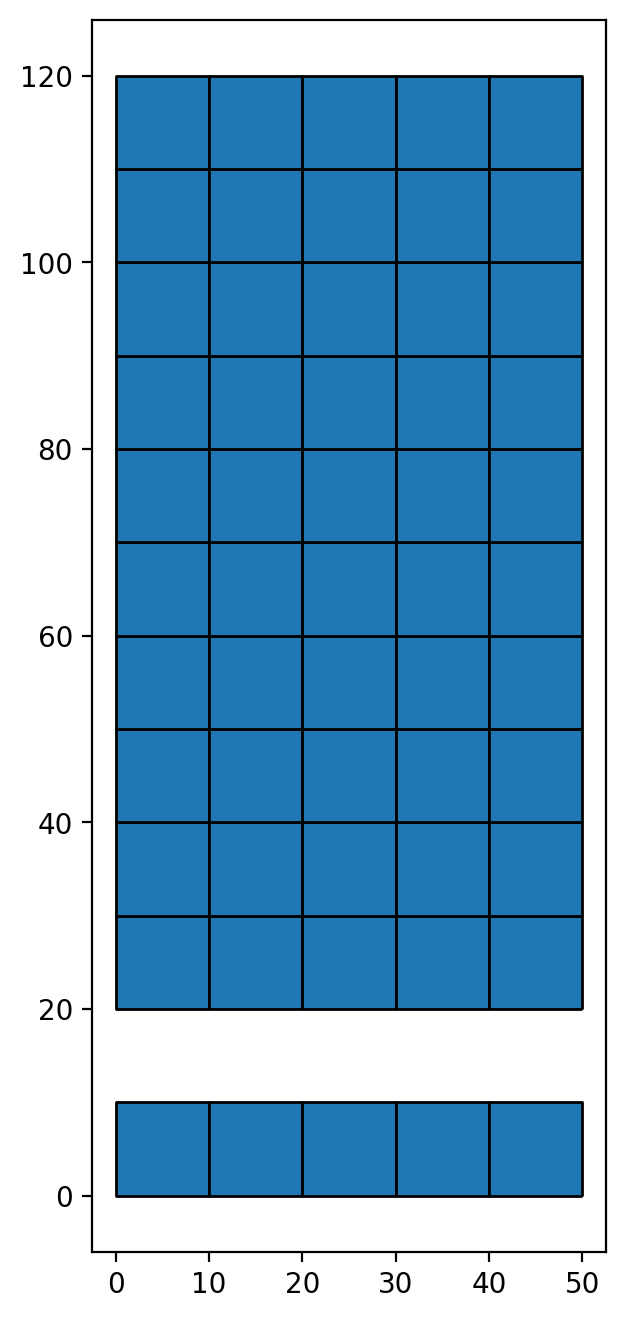

In [14]:
from spopt.region.maxp import infeasible_components

gdf = geopandas.GeoDataFrame(
    geometry=geometries,
    data=numpy.ones((n_cols * n_rows + n_cols, 1), int),
    columns=["var"],
)
gdf.plot(edgecolor="black");

In [15]:
model = MaxP(gdf, w, "var", "var", 6, 2, policy="drop")
model.solve()
ifcs = infeasible_components(gdf, w, "var", 6)
keep_ids = numpy.where(~numpy.isin(w.component_labels, ifcs))[0]
gdf["region"] = -1
gdf.loc[keep_ids, "region"] = model.labels_
gdf.explore(column="region", categorical=True)  # areas in region -1 are dropped

## No Feasible Components
We also handle the case when none of the components are feasible by rasing an exception.

In [16]:
model = MaxP(gdf, w, "var", "var", 55, 2, policy="drop")
try:
    model.solve()
except Exception as e:
    print(e)

No feasible components found in input.


-----------------